In [1]:
!pip install tensorflow

In [2]:
!pip install wordcloud
!pip install nltk

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [5]:
#loading the data
train_data=pd.read_csv("train.txt", header=None, sep=';', names=['comment','Emotion'], encoding='utf-8')
train_data['length']=[len(x) for x in train_data['comment']]

In [6]:
train_data

,comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
16128,i find peace in her voice,love,25
16129,his kindness warms my days,love,26
16130,i feel lifted by her care,love,25
16131,her trust strengthens my soul,love,29


In [7]:
train_data.shape

(16133, 3)

In [8]:
train_data.isnull().sum()

,0
comment,0
Emotion,0
length,0


In [9]:
train_data.duplicated().sum()

np.int64(2)

In [10]:
train_data.drop_duplicates(inplace=True)

In [11]:
#eda
train_data['Emotion'].value_counts()

,count
Emotion,
joy,5361
sadness,4666
anger,2159
fear,1937
love,1436
surprise,572


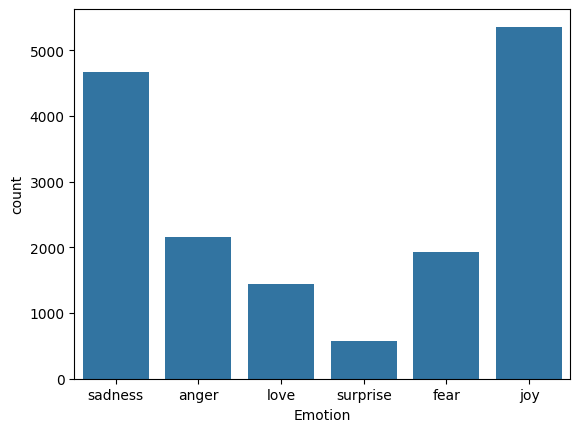

In [12]:
sns.countplot(x='Emotion', data=train_data)
plt.show()

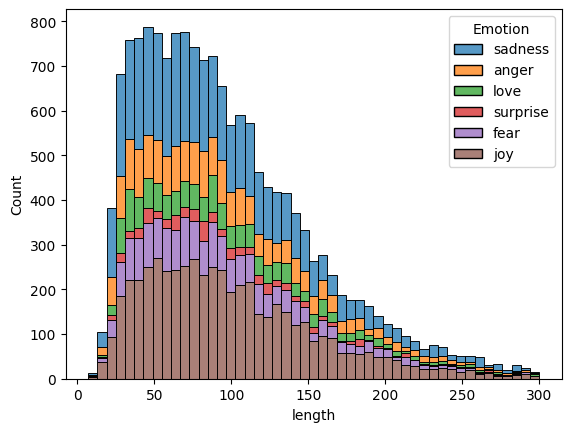

In [13]:
#data distribution
df=train_data.copy()
lenght_values=df['length'].values
sns.histplot(data=df, x='length', hue='Emotion', multiple='stack')
plt.show()

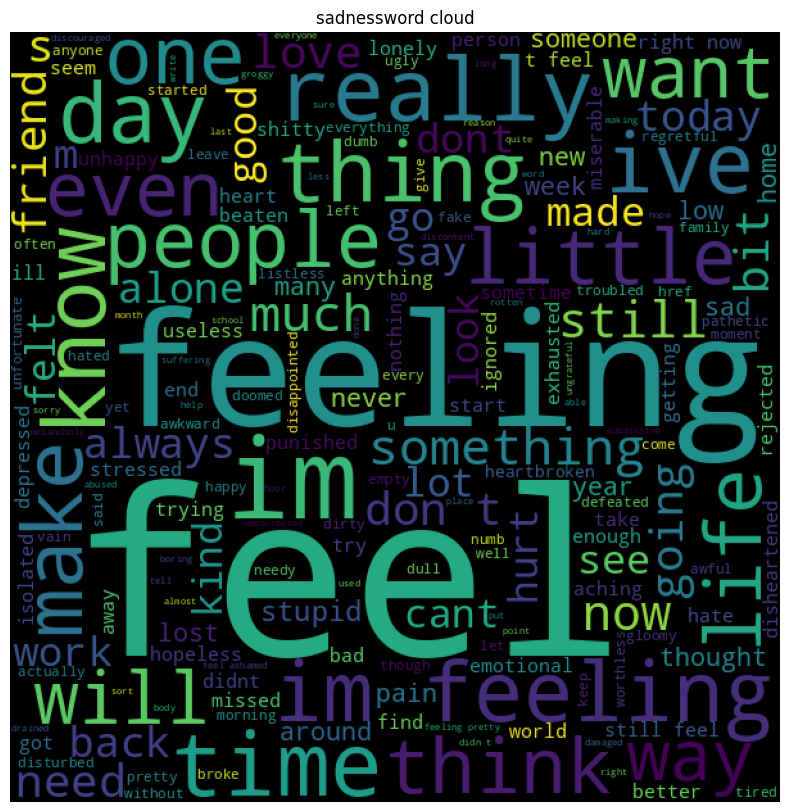

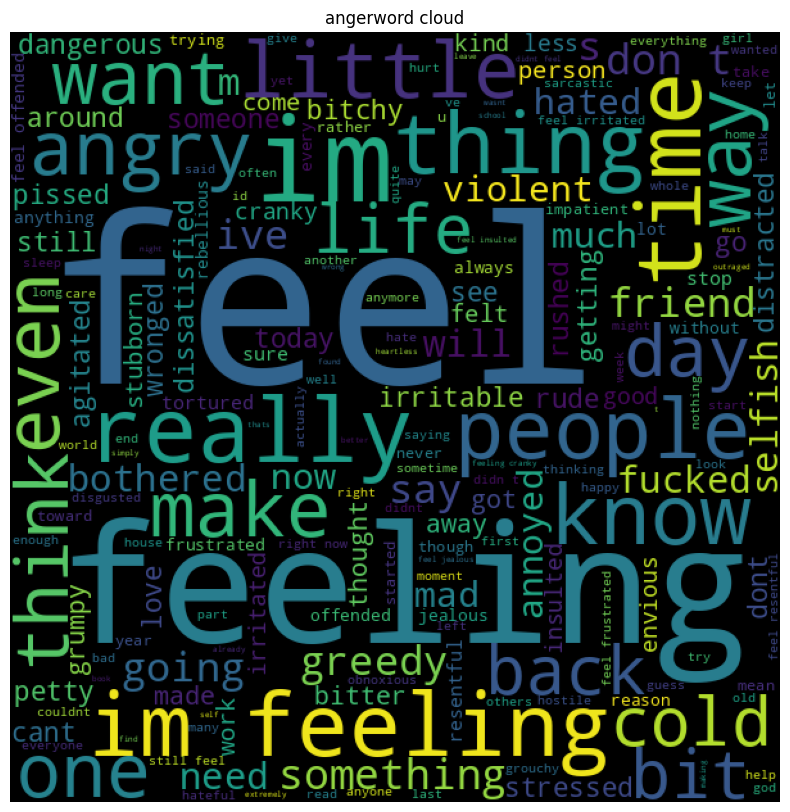

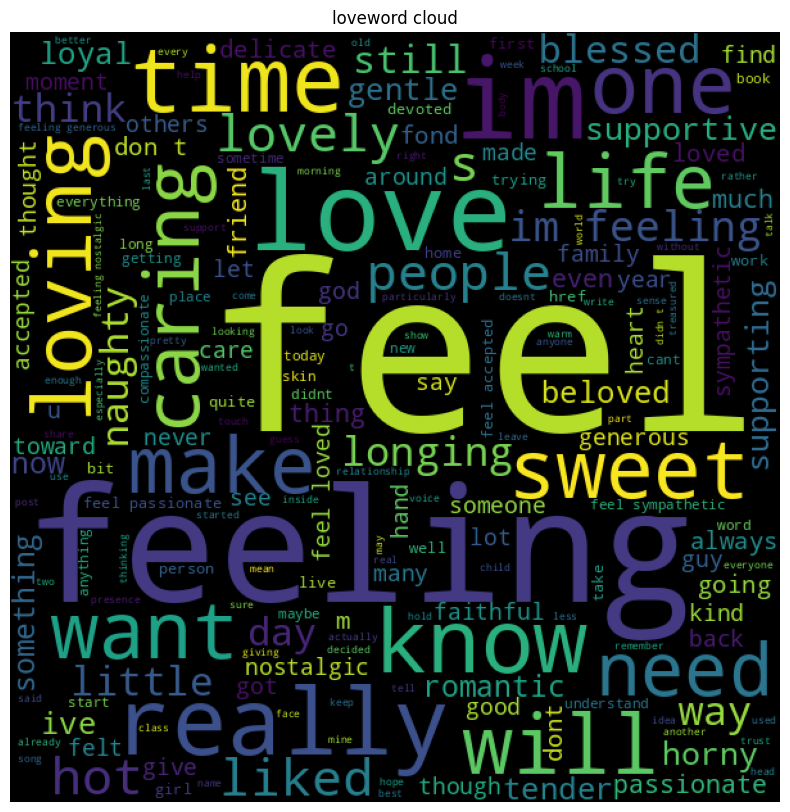

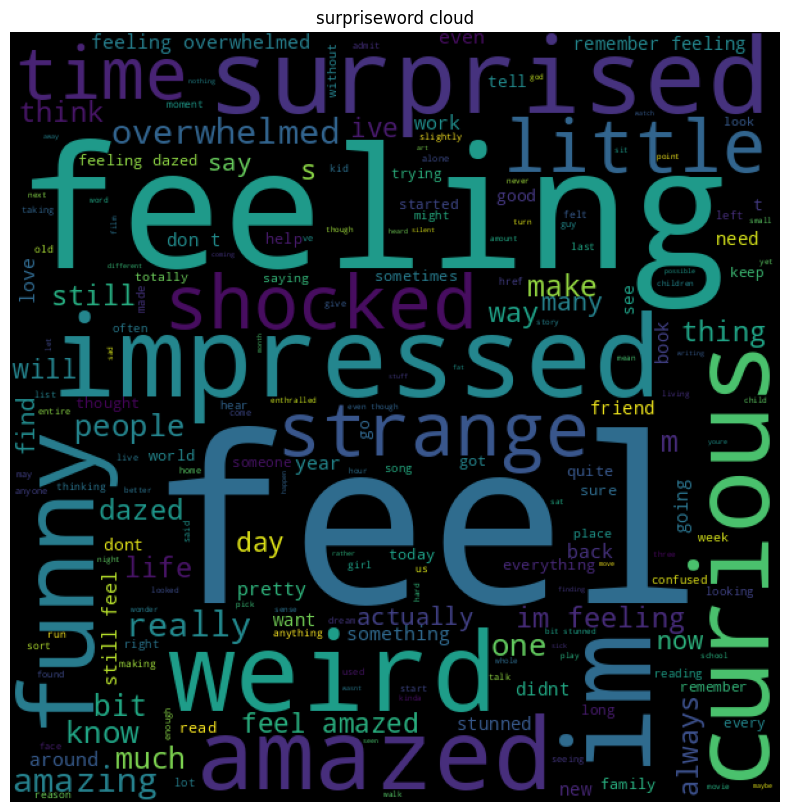

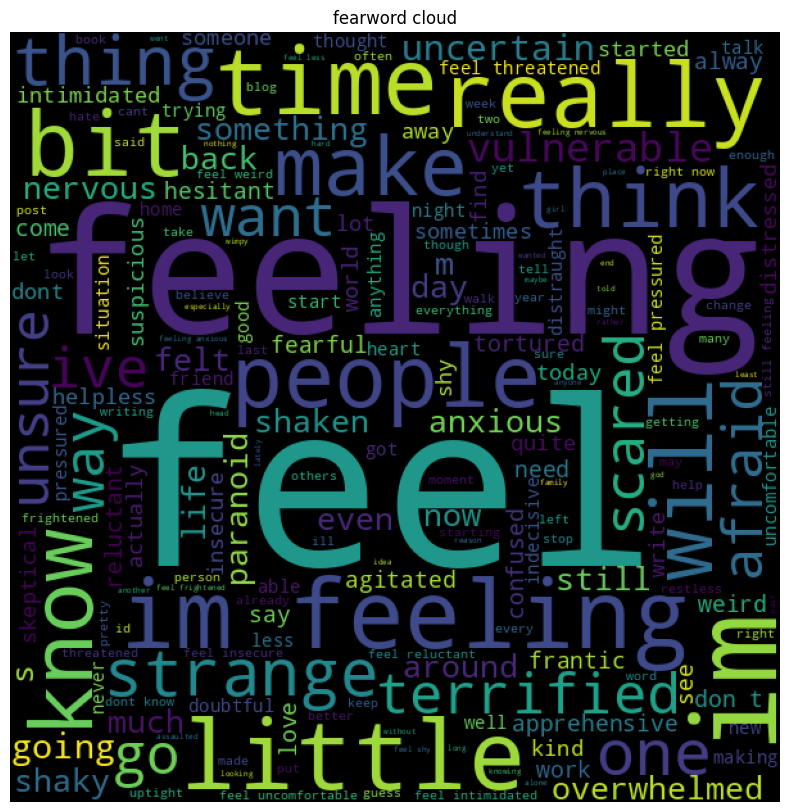

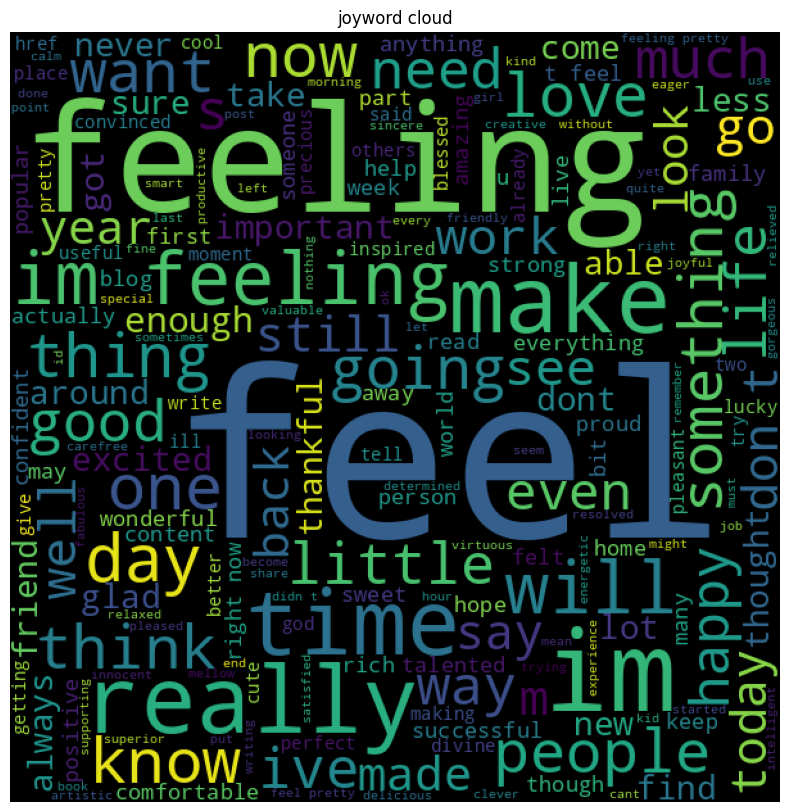

In [14]:
#words cloud for each_emotions
def word_cloud(wordcloud, df):
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(df+"word cloud")

emotion_list=train_data['Emotion'].unique()
for emotion in emotion_list:
  text=" ".join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion, 'comment']])
  wordcloud = WordCloud(width=600, height=600).generate(text)
  word_cloud(wordcloud, emotion)

In [15]:
#data preprocessing
#encoding the emotions
lb=LabelEncoder()


train_data['Emotion_Encoder']=lb.fit_transform(train_data['Emotion'])

In [16]:
train_data

,comment,Emotion,length,Emotion_Encoder
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
16127,her guidance lights my way,love,26,3
16128,i find peace in her voice,love,25,3
16129,his kindness warms my days,love,26,3
16130,i feel lifted by her care,love,25,3


In [17]:
#applying the machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [18]:
df=train_data.copy()

In [19]:
df

,comment,Emotion,length,Emotion_Encoder
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
16127,her guidance lights my way,love,26,3
16128,i find peace in her voice,love,25,3
16129,his kindness warms my days,love,26,3
16130,i feel lifted by her care,love,25,3


In [20]:
#datacleaning and preprocessing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stopwords=set(nltk.corpus.stopwords.words('english'))

In [22]:
def clean_text(text):
  stemmer=PorterStemmer()
  text=re.sub('[^a-zA-Z]', ' ', text)
  text=text.lower()
  text=text.split()
  text=[stemmer.stem(word) for word in text if word not in stopwords]
  return text
clean_text("I am 2345 % loving  hating, hated, loved")
df['cleaned_comment']=df['comment'].apply(clean_text)

In [23]:
df

,comment,Emotion,length,Emotion_Encoder,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,"[didnt, feel, humili]"
1,i can go from feeling so hopeless to so damned...,sadness,108,4,"[go, feel, hopeless, damn, hope, around, someo..."
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,"[im, grab, minut, post, feel, greedi, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,92,3,"[ever, feel, nostalg, fireplac, know, still, p..."
4,i am feeling grouchy,anger,20,0,"[feel, grouchi]"
...,...,...,...,...,...
16127,her guidance lights my way,love,26,3,"[guidanc, light, way]"
16128,i find peace in her voice,love,25,3,"[find, peac, voic]"
16129,his kindness warms my days,love,26,3,"[kind, warm, day]"
16130,i feel lifted by her care,love,25,3,"[feel, lift, care]"


In [24]:
#train_test_split
X_train, X_test, y_train, y_test=train_test_split(df['cleaned_comment'], df['Emotion_Encoder'], test_size=0.2, random_state=42)

In [25]:
 X_train

,cleaned_comment
9983,"[feel, pathet, ask, could, even, let, thing, g..."
2525,"[alway, plant, big, section, lettuc, leav, ope..."
11406,"[feel, less, alon, like, belong]"
10097,"[feel, confid, draw, ill, post, em]"
5802,"[feel, alon, anymor]"
...,...
13418,"[love, leav, reader, feel, confus, slightli, d..."
5390,"[feel, delic]"
860,"[start, feel, littl, stress]"
15796,"[feel, accept, music, critic, reinforc, concep..."


In [26]:
#vectorization using TF-IDF
# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert lists of tokens to strings
X_train = [' '.join(tokens) for tokens in X_train]
X_test = [' '.join(tokens) for tokens in X_test]

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [27]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 115068 stored elements and shape (12904, 9235)>

In [28]:
import xgboost as xgb
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC(),
    "XGB": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
for name,clf in classifiers.items():
  print(f"\n============================={name}======================")
  clf.fit(X_train_tfidf, y_train)
  y_pred=clf.predict(X_test_tfidf)
  accuracy_tfidf=accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy_tfidf}")

  print("classification_report")
  print(classification_report(y_test, y_pred))


=============================MultinomialNB======================
Accuracy: 0.6678029129222188
classification_report
              precision    recall  f1-score   support

           0       0.92      0.34      0.49       438
           1       0.91      0.23      0.37       367
           2       0.60      0.97      0.74      1061
           3       1.00      0.08      0.15       293
           4       0.71      0.92      0.80       947
           5       1.00      0.01      0.02       121

    accuracy                           0.67      3227
   macro avg       0.86      0.42      0.43      3227
weighted avg       0.76      0.67      0.60      3227


=============================LogisticRegression======================
Accuracy: 0.8308026030368764
classification_report
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       438
           1       0.84      0.73      0.78       367
           2       0.78      0.94      0.85      1061
 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:02:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8521846916640843
classification_report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       438
           1       0.82      0.81      0.82       367
           2       0.82      0.91      0.86      1061
           3       0.79      0.65      0.72       293
           4       0.93      0.88      0.91       947
           5       0.69      0.77      0.73       121

    accuracy                           0.85      3227
   macro avg       0.82      0.81      0.82      3227
weighted avg       0.85      0.85      0.85      3227



In [29]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
def clean_text(text):
    import re
    from nltk.stem import PorterStemmer
    from nltk.corpus import stopwords
    import nltk
    nltk.download('stopwords', quiet=True)

    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    return " ".join(text)

def predict_emotion_xgb(user_input):
    # Step 1: Clean the input
    cleaned = clean_text(user_input)

    # Step 2: TF-IDF transform
    vectorized = tfidf_vectorizer.transform([cleaned])  # must be a list of strings

    # Step 3: Predict using XGBoost
    pred_label = xgb_model.predict(vectorized)[0]  # e.g., 3
    pred_emotion = lb.inverse_transform([pred_label])[0]  # e.g., "love"

    return pred_emotion, pred_label

# 🔍 Example usage:
user_input = input("Enter a sentence to predict emotion: ")
emotion, encoded_label = predict_emotion_xgb(user_input)
print("Predicted Emotion:", emotion)
print("Encoded Label:", encoded_label)

Enter a sentence to predict emotion: his warm hug brings a peaceful ease to my soul
Predicted Emotion: love
Encoded Label: 3


In [32]:
max([len(w) for w in train_data['comment']])

300

In [33]:
stopwords=set(nltk.corpus.stopwords.words('english'))

In [34]:
def clean_text(df, column, vocab_size, max_len):
    ps = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        text = text.split()
        text = [ps.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_words = [one_hot(text, vocab_size) for text in corpus]
    padded_sequences = pad_sequences(one_hot_words, maxlen=max_len, padding='pre')

    return padded_sequences

X_train = clean_text(train_data, 'comment', vocab_size=11000, max_len=300)

In [35]:
X_train.shape

(16131, 300)

In [36]:
le = LabelEncoder()
train_data['Emotion_Label'] = le.fit_transform(train_data['Emotion'])

# Step 2: Convert integer labels to one-hot vectors
y_train = to_categorical(train_data['Emotion_Label'])

In [37]:
train_data

,comment,Emotion,length,Emotion_Encoder,Emotion_Label
0,i didnt feel humiliated,sadness,23,4,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3,3
4,i am feeling grouchy,anger,20,0,0
...,...,...,...,...,...
16127,her guidance lights my way,love,26,3,3
16128,i find peace in her voice,love,25,3,3
16129,his kindness warms my days,love,26,3,3
16130,i feel lifted by her care,love,25,3,3


In [38]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [39]:
X_train

array([[   0,    0,    0, ..., 8985, 9226, 8402],
       [   0,    0,    0, ..., 7359, 7733, 6026],
       [   0,    0,    0, ..., 9226, 6485, 9407],
       ...,
       [   0,    0,    0, ..., 6011, 9693, 1110],
       [   0,    0,    0, ..., 9226, 8209, 7733],
       [   0,    0,    0, ..., 1821, 5598, 6877]], dtype=int32)

In [40]:
#model building and training
model = Sequential()
model.add(Embedding(input_dim=110000, output_dim=150, input_length=300))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.3617 - loss: 1.5562
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8496 - loss: 0.4634
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9271 - loss: 0.2173
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9443 - loss: 0.1568
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9573 - loss: 0.1181
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9625 - loss: 0.0973
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9667 - loss: 0.0896
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9709 - loss: 0.0751
Epoch 9/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9741 - loss: 0.0667
Epoch 10/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9780 - loss: 0.0537
Epoch 11/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9804 - loss: 0.0532
Epoch 12/20
253/253 ━━━━━━━━━━━━━━━━

In [45]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Only run once
import nltk
nltk.download('stopwords')

# 1. Preprocessing function
def preprocess_user_input(text, vocab_size=11000, max_len=300):
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    text = " ".join(text)

    one_hot_encoded = [one_hot(text, vocab_size)]
    padded = pad_sequences(one_hot_encoded, maxlen=max_len, padding='pre')

    return padded

# 2. Predict emotion
user_input = input("Enter a sentence to predict emotion: ")
processed_input = preprocess_user_input(user_input)

prediction = model.predict(processed_input)
predicted_label = prediction.argmax(axis=1)[0]
predicted_emotion = le.inverse_transform([predicted_label])[0]

print("Predicted Emotion:", predicted_emotion)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Enter a sentence to predict emotion: i’m stunned to find a unexpected gift waiting for me
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: joy
